The problem I recently encountered was handling nonhomogeneous boundary conditions on a given domain. However, there is an interesting property of decomposition for this case. This repository addresses such a problem using a Poisson solver on a rectangular domain, potentially employing Fourier transforms, which provides an efficient way to compute the solution compared to naively solving the linear system.

This Notebook allows you to solve the 2D Poisson equation as

$$
\nabla^2 u(x,y) = f(x,y)
$$

on a rectangular domain $\Omega = [0,L_x] \times [0,L_y]$ with either Dirichlet or Neumann boundary conditions. To deal with nonhomogenous Poisson equation on a domain with zero dirichelt or zero neumann boundary could be solved by Discrete Sine Transform or Discrete Cosine Transform respectively whose description appears later in this notebook.

Here the problem is decomposed as


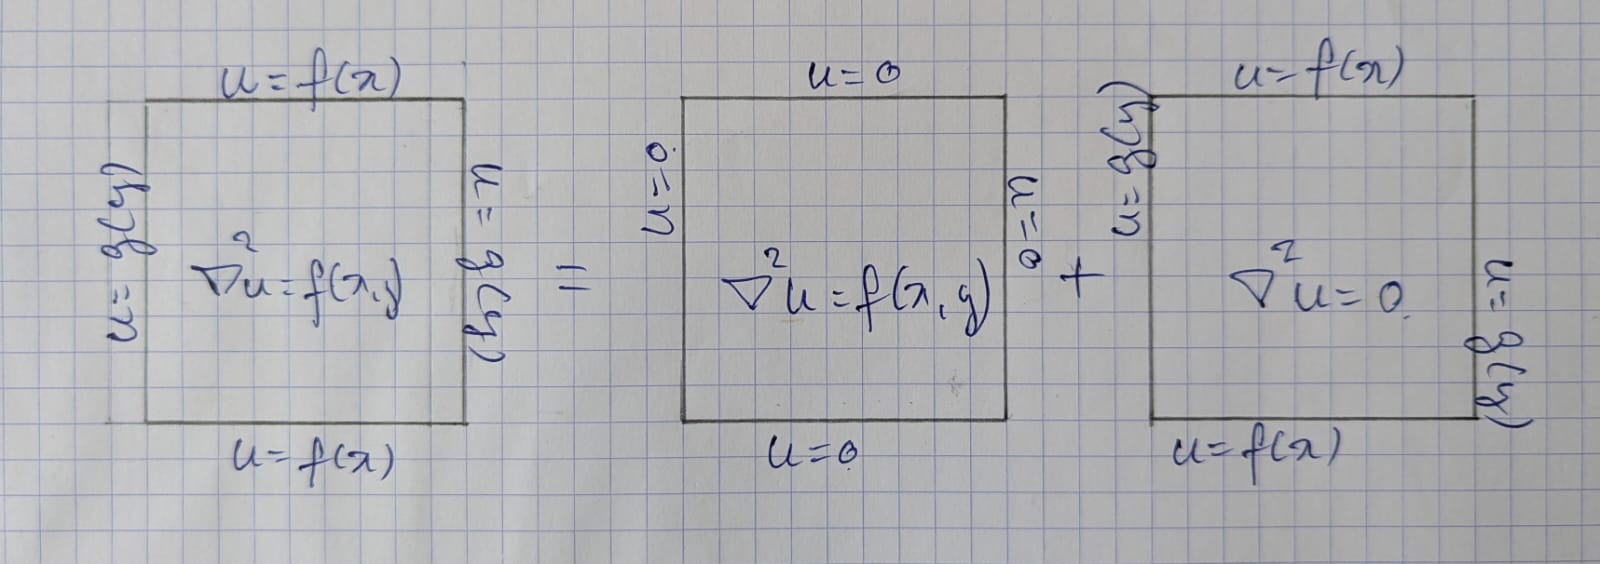

let say the original problem is given by $u(x,y)$ decomposed into a problem of $u_1(x,y)$ with homogenous boundary (i.e. $u=0$ or $\partial_n u = 0$) and $u_2(x,y)$ which solves Laplace equation with specified linear boundary.

We start by addressing two dimensional Poisson equation 

$\nabla^2 u(x,y) = f(x,y)$ where $(x,y) \in \Omega$ with either Dirichlet or Neumann boundary. Furthermore with decomposition ($u = u_1+u_2$), 

$u_1$ solves Poisson with homogenous boundary as

$$
\nabla^2 u_1 = f, \, \text{where} \, u_1 = 0 \, \text{or} \, \partial_n u_1 = 0 \, \text{on} \, \partial\Omega 
$$

Similarly, for $u_2$ with a nonzero boundary as

$$
\nabla^2 u_2 = 0, \, u_2 = g(x,y) \quad \text{or} \quad
\nabla^2 u_2 = 0, \, \partial_n u_2 = g(x,y)
$$

Then clearly,

$$
\nabla^2 (u_1 + u_2) = \nabla^2 u_1 + \nabla^2 u_2 = f + 0 = f
$$

and by following the discretsation of a uniform grid with spacing $h_x, h_y$ and 5-point finite difference:

$$
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2}
$$

$$
\frac{\partial^2 u}{\partial y^2} \approx \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2}
$$

and discretising the interior equation as 

$$
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2} = f_{i,j}
$$

With spectral diagonalization for Dirichlet boundary, Discrete Sine transform is used where Sine functions vanish at boundaries, and inherently statisying the Dirichlet condition.

$$
\sin\left(\frac{n \pi x}{L}\right) = 0 \quad \text{at } x=0,L
$$

Expand interior solution:

$$
u_{i,j} = \sum_{p=1}^{N_x} \sum_{q=1}^{N_y} U_{p,q} \sin\left(\frac{p \pi i}{N_x + 1}\right) \sin\left(\frac{q \pi j}{N_y + 1}\right)
$$

Eigenvalues of discrete Laplacian:

$$
\lambda_{p,q} = \frac{2}{h_x^2} \left( 1 - \cos \frac{p \pi}{N_x + 1} \right) + \frac{2}{h_y^2} \left( 1 - \cos \frac{q \pi}{N_y + 1} \right)
$$

Solve spectral coefficients:

$$
U_{p,q} = \frac{\hat{F}_{p,q}}{\lambda_{p,q}}
$$

And for Neumann BC, Discrete Cosine transform is used where Cosine functions vanish at boundaries, and inherently statisying the Neumann condition.

$$
\frac{d}{dx} \cos\left(\frac{n \pi x}{L}\right) = 0 \quad \text{at } x=0,L
$$

Expansion:

$$
u_{i,j} = \sum_{p=0}^{N_x-1} \sum_{q=0}^{N_y-1} U_{p,q} \cos\left(\frac{p \pi i}{N_x}\right) \cos\left(\frac{q \pi j}{N_y}\right)
$$

The zero-frequency mode corresponds to an arbitrary constant (Neumann BCs determine solution up to constant).

Let us have a glimse at the boundary contributions,

For nonzero Dirichlet BCs:

$$
f_{i,j} \rightarrow f_{i,j} - \frac{u_\text{boundary}}{h^2}
$$

For Neumann BCs, derivative contributions are added to the RHS with proper signs. Functions \texttt{dirchilet\_bc} or \texttt{add\_bc\_contrib} implement this.

And hence in the code, the algorithm is structured as

1. Compute $u_1$ using DST/DCT with zero BCs and forcing $f$.  
2. Compute $u_2$ solving Laplace with nonzero BCs.  
3. Combine: $u_\text{full} = u_1 + u_2$.

Efficiency: $O(N_x N_y \log(N_x N_y))$ using FFT-like transforms. Works for rectangular domains and uniform BC types.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dst, idst, dct, idct

In [2]:
# DST helpers
def dst2(a):
    return dst(dst(a, type=1, axis=0), type=1, axis=1)

def idst2(a):
    n, m = a.shape
    tmp = idst(idst(a, type=1, axis=0), type=1, axis=1)
    tmp *= (1.0/(2*(n+1))) * (1.0/(2*(m+1)))
    return tmp

# DCT helpers for Neumann BC
def dct2(a):
    return dct(dct(a, type=1, axis=0), type=1, axis=1)

def idct2(a):
    n, m = a.shape
    tmp = idct(idct(a, type=1, axis=0), type=1, axis=1)
    tmp *= (1.0/(2*(n-1))) * (1.0/(2*(m-1)))
    return tmp

# Boundary contributions to RHS
def add_bc_contrib(rhs, bottom, top, left, right, hx, hy, BC_type='Dirichlet'):
    rhs2 = rhs.copy()
    if BC_type == 'Dirichlet':
        rhs2[:,0] -= bottom / hy**2
        rhs2[:,-1] -= top / hy**2
        rhs2[0,:] -= left / hx**2
        rhs2[-1,:] -= right / hx**2
    elif BC_type == 'Neumann':
        rhs2[:,0] += bottom / hy**2
        rhs2[:,-1] -= top / hy**2
        rhs2[0,:] += left / hx**2
        rhs2[-1,:] -= right / hx**2
    return rhs2

# Spectral solver
def psi_zbc(f_int, hx, hy, BC_type='Dirichlet'):
    Nx, Ny = f_int.shape
    ix = np.arange(1, Nx+1)
    iy = np.arange(1, Ny+1)
    if BC_type == 'Dirichlet':
        Fhat = dst2(f_int)
        lam_x = 2*(1 - np.cos(np.pi*ix/(Nx+1)))/hx**2
        lam_y = 2*(1 - np.cos(np.pi*iy/(Ny+1)))/hy**2
        denom = lam_x[:, None] + lam_y[None, :]
        Uhat = Fhat / denom
        u = idst2(Uhat)
    elif BC_type == 'Neumann':
        Fhat = dct2(f_int)
        lam_x = 2*(1 - np.cos(np.pi*(ix-1)/Nx))/hx**2
        lam_y = 2*(1 - np.cos(np.pi*(iy-1)/Ny))/hy**2
        denom = lam_x[:, None] + lam_y[None, :]
        denom[0,0] = 1.0
        Uhat = Fhat / denom
        Uhat[0,0] = 0.0
        u = idct2(Uhat)
    else:
        raise ValueError("BC_type must be 'Dirichlet' or 'Neumann'")
    return u


In [3]:
def int_solver(freq=1.0, ampli=1.0, Nx=64, Ny=64, BC_type='Dirichlet'):
    Lx, Ly = 1.0, 1.0
    hx, hy = Lx/(Nx+1), Ly/(Ny+1)
    x = np.linspace(hx, Lx-hx, Nx)
    y = np.linspace(hy, Ly-hy, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # Forcing and BCs
    f = ampli * np.sin(np.pi*freq*X) * np.sin(np.pi*freq*Y)
    bottom = ampli * np.sin(np.pi*freq*x)
    top = np.zeros_like(x)
    left = np.zeros_like(y)
    right = np.zeros_like(y)
    
    # Solve u1 and u2
    u1 = psi_zbc(f, hx, hy, BC_type=BC_type)
    rhs_u2 = np.zeros_like(f)
    rhs_u2 = add_bc_contrib(rhs_u2, bottom, top, left, right, hx, hy, BC_type=BC_type)
    u2 = psi_zbc(rhs_u2, hx, hy, BC_type=BC_type)
    rhs_f = f.copy()
    rhs_f = add_bc_contrib(rhs_f, bottom, top, left, right, hx, hy, BC_type=BC_type)
    u_f = psi_zbc(rhs_f, hx, hy, BC_type=BC_type)
    
    # Plot results
    fig, ax = plt.subplots(1,3, figsize=(15,4))
    ax[0].imshow(u_f.T, origin='lower', extent=[0,Lx,0,Ly], aspect='auto'); ax[0].set_title(r'Final solution on $u$')
    ax[1].imshow(u1.T, origin='lower', extent=[0,Lx,0,Ly], aspect='auto'); ax[1].set_title(r'$u_1$')
    ax[2].imshow(u2.T, origin='lower', extent=[0,Lx,0,Ly], aspect='auto'); ax[2].set_title(r'$u_2$')
    for a in ax: plt.colorbar(a.images[0], ax=a)
    plt.show()


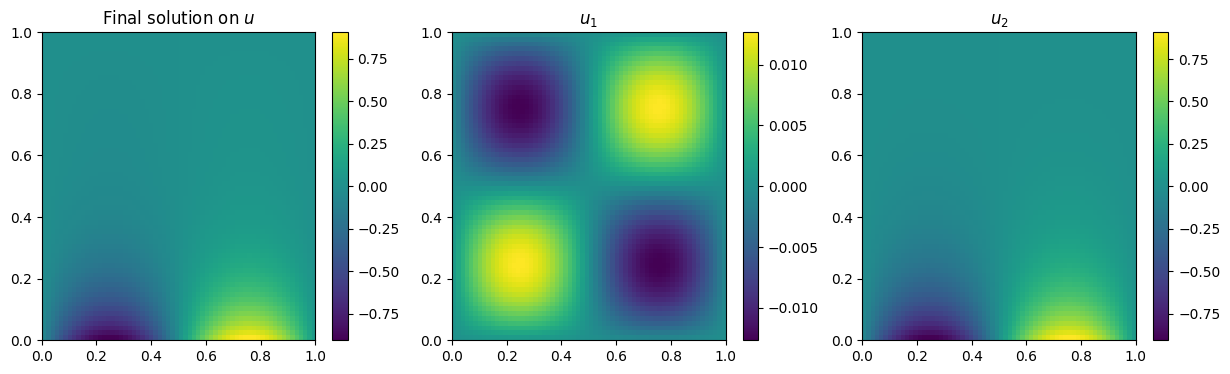

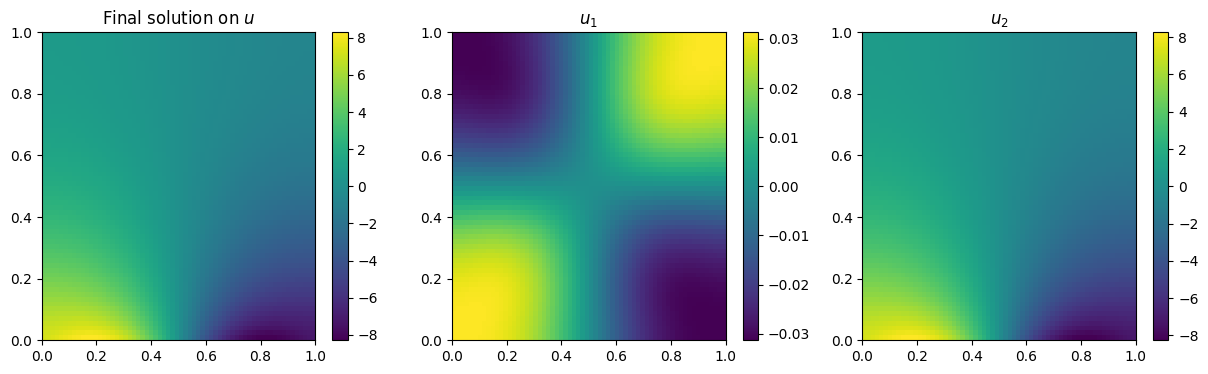

In [4]:
freq = 2        # frequency multiplier
amplitude = 1   # source amplitude
Nx, Ny = 64, 64
BC_type = "Dirichlet"   # or "Neumann"

# Domain
Lx, Ly = 1.0, 1.0
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# Source term
f = amplitude * np.sin(freq * np.pi * X) * np.sin(freq * np.pi * Y)


if BC_type == "Dirichlet":
    u = np.sin(freq * np.pi * X) * np.sin(freq * np.pi * Y)
else:  # Neumann
    u = np.cos(freq * np.pi * X) * np.cos(freq * np.pi * Y)


int_solver(freq=2, ampli=1, Nx=64, Ny=64, BC_type="Dirichlet")
int_solver(freq=2, ampli=1, Nx=64, Ny=64, BC_type="Neumann")


N= 32, rel_err=7.556e-04, time=0.001 s
N= 64, rel_err=1.947e-04, time=0.001 s
N=128, rel_err=4.943e-05, time=0.002 s
N=256, rel_err=1.245e-05, time=0.029 s


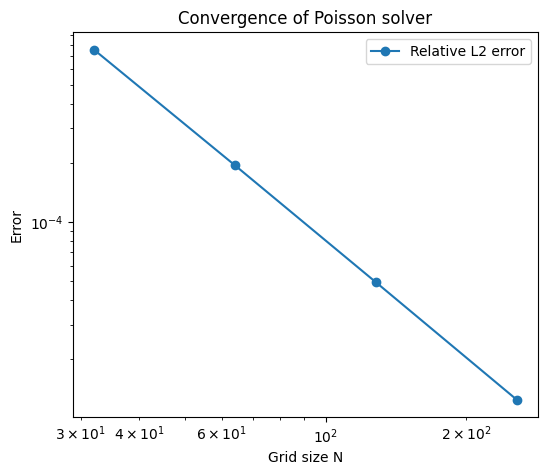

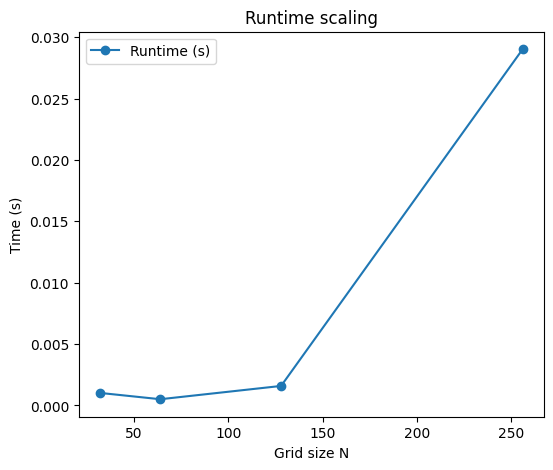

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

def conv(grid=[32, 64, 128, 256]):
    Lx, Ly = 1.0, 1.0
    err = []
    rtime = []

    for N in grid:
        Nx, Ny = N, N
        hx, hy = Lx/(Nx+1), Ly/(Ny+1)

        x = np.linspace(hx, Lx-hx, Nx)
        y = np.linspace(hy, Ly-hy, Ny)
        X, Y = np.meshgrid(x, y, indexing='ij')

        # Exact solution and forcing
        u_exact = np.sin(np.pi*X) * np.sin(np.pi*Y)
        f = 2*np.pi**2 * np.sin(np.pi*X) * np.sin(np.pi*Y)

        # Zero BCs
        bottom = np.zeros_like(x)
        top = np.zeros_like(x)
        left = np.zeros_like(y)
        right = np.zeros_like(y)

        # Time taken by the solver
        t0 = time.time()
        u_num = psi_zbc(f, hx, hy, BC_type="Dirichlet")   # <-- your solver
        elapsed = time.time() - t0

        # Relative error
        rel_err = np.linalg.norm(u_num - u_exact) / np.linalg.norm(u_exact)

        err.append(rel_err)
        rtime.append(elapsed)
        print(f"N={N:3d}, rel_err={rel_err:.3e}, time={elapsed:.3f} s")
    
    err = np.array(err)
    rtime = np.array(rtime)

    return grid, err, rtime


grid, err, rtime = conv()

# Error vs grid size
plt.figure(figsize=(6,5))
plt.loglog(grid, err, 'o-', label="Relative L2 error")
plt.xlabel("Grid size N")
plt.ylabel("Error")
plt.title("Convergence of Poisson solver")
plt.legend()
plt.show()

# Time vs grid size
plt.figure(figsize=(6,5))
plt.plot(grid, rtime, 'o-', label="Runtime (s)")
plt.xlabel("Grid size N")
plt.ylabel("Time (s)")
plt.title("Runtime scaling")
plt.legend()
plt.show()
